In [ ]:
import sys
import torch
import yaml
from pathlib import Path
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# %load_ext autoreload
# %reload_ext autoreload
# %autoreload 2
# %matplotlib inline


In [ ]:
# The code cell is used to add the src directory to the Python path, making
# itinference_csv_pathimport modules from that directory.

# used to add the src directory to the Python path, making
# it possible to import modules from that directory.
module_path = Path("..", "src").resolve().as_posix()
sys.path.insert(0, module_path)

# Try importing the custom modules from the src directory
# NOTE how `utils` is getting imported. This is to avoid conflict with built-in python library named 'utils'
try:
    from custom_dataset import CropData
    import utils as u
    from models.unet import Unet
    from model_compiler import ModelCompiler
    from custom_loss_functions import (
        BalancedCrossEntropyLoss,
        BinaryTverskyFocalLoss,
        TverskyFocalLoss,
        BalancedTverskyFocalLoss,
        TverskyFocalCELoss,
        BalancedTverskyFocalCELoss,
    )
except ModuleNotFoundError:
    print("Module not found")
    pass

# dictionary to map criterion names to their corresponding classes.
# These loss functions are defined in the custom_loss_functions.py file
CRITERION_DICT = {
    "BalancedCrossEntropyLoss": BalancedCrossEntropyLoss,
    "BinaryTverskyFocalLoss": BinaryTverskyFocalLoss,
    "TverskyFocalLoss": TverskyFocalLoss,
    "BalancedTverskyFocalLoss": BalancedTverskyFocalLoss,
    "TverskyFocalCELoss": TverskyFocalCELoss,
    "BalancedTverskyFocalCELoss": BalancedTverskyFocalCELoss,
    "CrossEntropyLoss": nn.CrossEntropyLoss,
}


def get_criterion(criterion_name, criterion_params):
    if criterion_name in CRITERION_DICT:
        criterion_class = CRITERION_DICT[criterion_name]
        # Extract only the parameters that are provided in the configuration
        params = {k: v for k, v in criterion_params.items() if v is not None}
        return criterion_class(**params)
    else:
        raise ValueError(f"Unsupported criterion: {criterion_name}")


def load_config(yaml_config_path, num_time_points):
    with open(yaml_config_path, "r") as file:
        config = yaml.load(file, Loader=yaml.SafeLoader)

    for key, value in config["global_stats"].items():
        config["global_stats"][key] = value * num_time_points

    keys_with_paths = [
        "dataset_path",
        "train_csv_path",
        "inference_csv_path",
        "validation_csv_path",
        "tensorboard_log_path",
    ]
    for key in keys_with_paths:
        config[key] = Path(config[key]).resolve().as_posix()

    if config["params_init"]:
        config["params_init"] = Path(config["params_init"]).resolve().as_posix()

    # Initialize the SummaryWriter by setting the directory where to save the event files
    # The events.out.tfevents files are created by TensorBoard to log events from all training events
    writer = SummaryWriter(log_dir=config["tensorboard_log_path"])

    return config


In [ ]:
# The code cell loads a configuration file (default_config.yaml) using the YAML library and stores the
# configuration data in the config dictionary. Then, it processes the global_stats section of the config
# dictionary by expanding the lists for each stats based on the number of available time points.
# As you can see we decided to generate a single set of normalization statistics and use it to
# normalize all the time-points.

# Enter the path to the config file or else keep blank to use the default config file.
user_input_path = None

if user_input_path:
    yaml_config_path = Path(user_input_path)
else:
    root_dir = Path("../").resolve()
    yaml_config_path = Path(root_dir, "config", "default_config.yaml")
num_time_points = 3  # Change this number accordingly if you use a dataset with a different temporal length.
config = load_config(yaml_config_path, num_time_points)


In [ ]:
# OPTIONAL
# pretty-print the config dictionary

import pprint

pprint.pprint(config, width=100, compact=True)


### Steps for training and finetuning

In [ ]:
# STEP 1-1: Data Preparation and Loading
# This code cell reads the input dataset for training, pre-processes it, and creates a 'torch.utils.Dataset'
# object to be used in the model training process. It utilizes the 'CropData' class from the custom module
# (CropData.py) to achieve this.

train_dataset = CropData(
    src_dir=config["dataset_path"],
    usage="train",
    dataset_name=config["dataset_dir"],
    csv_path=config["train_csv_path"],
    apply_normalization=config["apply_normalization"],
    normal_strategy=config["normal_strategy"],
    stat_procedure=config["stat_procedure"],
    global_stats=config["global_stats"],
    trans=config["transformations"],
    **config["aug_params"]
)


100%|██████████| 787/787 [00:19<00:00, 40.02it/s]

------ train dataset with 787 patches created ------


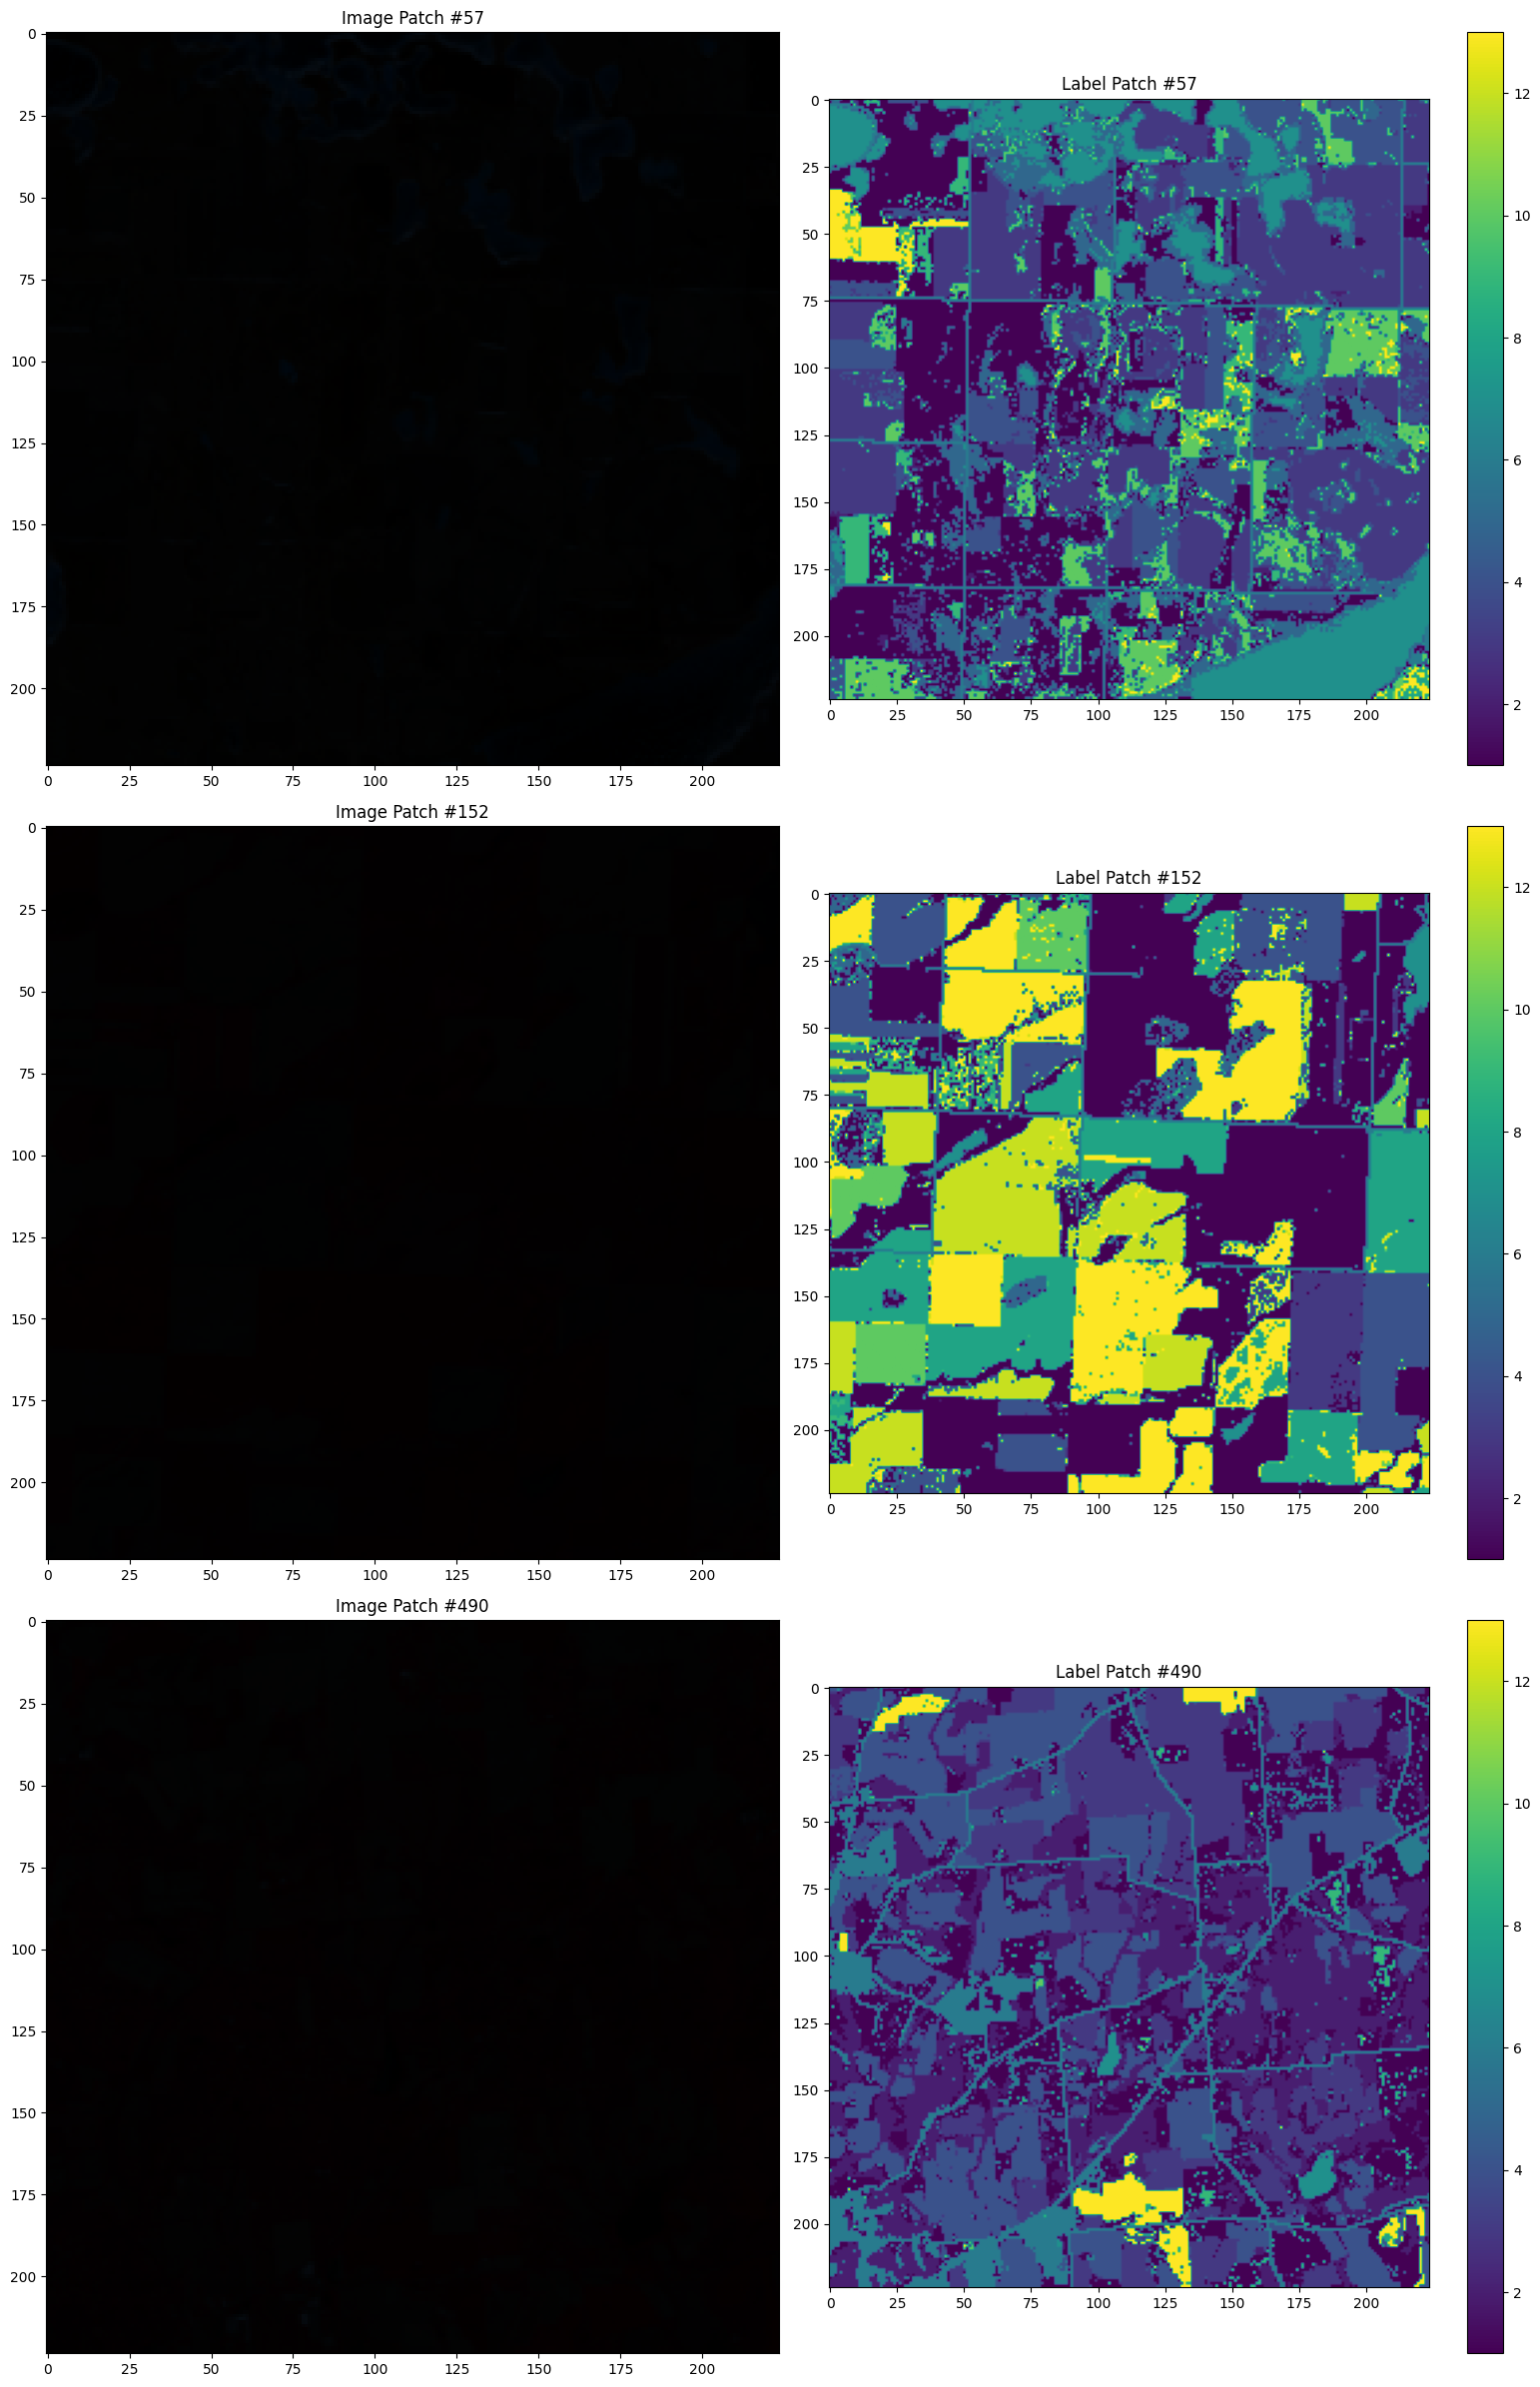

In [ ]:
# OPTIONAL

u.show_random_patches(train_dataset, sample_num=3, rgb_bands=(3, 2, 1))


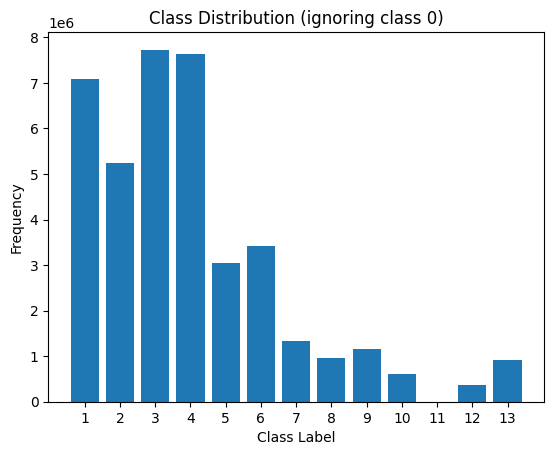

In [ ]:
# OPTIONAL
# Check the distribution of categories in a dataset

labels_count = u.get_labels_distribution(train_dataset, num_classes=14, ignore_class=0)
u.plot_labels_distribution(labels_count)


In [ ]:
# STEP 1-2: Data Batching and Device Assignment
# This code cell batchifies the training dataset using the 'DataLoader' class from PyTorch. The 'DataLoader'
# efficiently loads the 'train_dataset' in batches, facilitating memory management during training.

train_loader = DataLoader(
    train_dataset, batch_size=config["train_BatchSize"], shuffle=True
)


In [ ]:
# STEP 1-3
# Read the input dataset for validation, pre-process it and generate a 'torch.utils.Dataset' object
# that can be accepted to get loaded into the model.

val_dataset = CropData(
    src_dir=config["dataset_path"],
    usage="validation",
    dataset_name=config["dataset_dir"],
    csv_path=config["validation_csv_path"],
    apply_normalization=config["apply_normalization"],
    normal_strategy=config["normal_strategy"],
    stat_procedure=config["stat_procedure"],
    global_stats=config["global_stats"],
)


100%|██████████| 197/197 [00:04<00:00, 40.68it/s]

------ validation dataset with 197 patches created ------


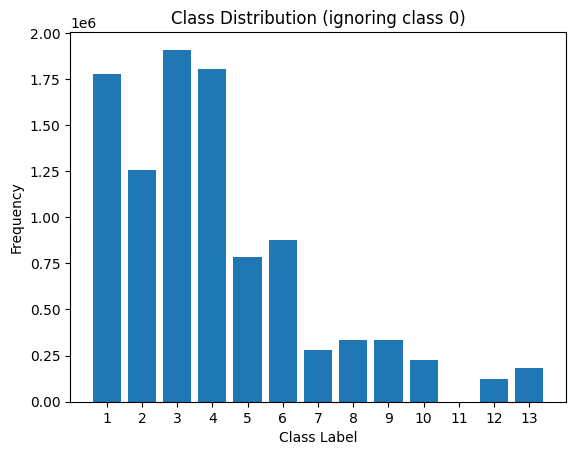

In [ ]:
# OPTIONAL
# Check the distribution of categories in a dataset

labels_count = u.get_labels_distribution(val_dataset)
u.plot_labels_distribution(labels_count)


In [ ]:
# STEP 1-4
# Batchify the validation dataset and put it on the defined 'Device'.

val_loader = DataLoader(
    val_dataset, batch_size=config["val_test_BatchSize"], shuffle=False
)


In [ ]:
# STEP 2: Model Initialization
# The model is based on the U-Net architecture, a popular choice for image segmentation tasks.

model = Unet(
    n_classes=config["n_classes"],
    in_channels=config["input_channels"],
    use_skipAtt=config["use_skipAtt"],
    filter_config=config["filter_config"],
    dropout_rate=config["train_dropout_rate"],
)


In [ ]:
# STEP 3: Model Compilation and Training Setup
# This code cell compiles the deep learning model, making it ready for training and evaluation. The 'ModelCompiler'
# class is employed for this purpose, which offers a set of essential functionalities, such as model training
# ('fit'), model saving, accuracy evaluation ('accuracy_evaluation'), inference ('inference'), and checkpointing
# with resume capabilities. Additionally, it generates tensorboard reports and graphs for monitoring the training
# process.

# Note: For training from scratch pass the "params_init" and "freeze_params" as None which results in loading a vanilla
# model with random initialization based on the "model_init_type" parameter. For training with warmup, only change the
# "params_init" to the path to model's saved parameter (not a checkpoint). For fine-tuning, change the "params_init" to
# the path to model's saved parameter (by default its in the chckpt folder in working directory) and pass a list of integers
# representing the index of layers to be frozen.

compiled_model = ModelCompiler(
    model,
    working_dir=config["working_dir"],
    out_dir=config["out_dir"],
    num_classes=config["n_classes"],
    inch=config["input_channels"],
    class_mapping=config["class_mapping"],
    gpu_devices=config["gpuDevices"],
    model_init_type=config["init_type"],
    params_init=config["params_init"],
    freeze_params=config["freeze_params"],
)


----------GPU available----------
initialize network with kaiming.
total number of trainable parameters: 103.4M
---------- Vanilla Model compiled successfully ----------


In [ ]:
# STEP 4: Model Training and Validation
# This code cell trains and validates the compiled deep learning model for the specified number of epochs.
# The model is trained using the "fit" method provided by the 'compiled_model' object. The training data
# is obtained from 'train_loader', which contains batched samples and labels. Additionally, the 'val_loader'
# is used for model validation during training. For each epoch the model reports the average loss value for both
# training and validation phases, providing insights into its generalization capabilities.

# During the training the "fit" method will create a folder called 'chkpt' inside your working directory
# and save the checkpoints in user-defined intervals in that folder.
# Note: In case the training process is interrupted, you can change the "resume" argument and pass in the
# epoch to resume based on the created checkpoints.

# Initialize the criterion for the loss function
criterion_name = config["criterion"]["name"]
criterion_params = config["criterion"]["parameters"]
criterion = get_criterion(criterion_name, criterion_params)

compiled_model.fit(
    train_loader,
    val_loader,
    epochs=config["epochs"],
    optimizer_name=config["optimizer"],
    lr_init=config["LR"],
    lr_policy=config["LR_policy"],
    criterion=criterion,
    momentum=config["momentum"],
    checkpoint_interval=config["checkpoint_interval"],
    resume=config["resume"],
    resume_epoch=config["resume_epoch"],
    **config["lr_prams"]
)


In [ ]:
# STEP 5
# Same model parameters
compiled_model.save(save_object="params")


In [ ]:
# STEP 6
# Generate the accuracy metrics.
compiled_model_metrics = compiled_model.accuracy_evaluation(
    val_loader, filename=config["val_metric_fname"]
)


### Steps for prediction

If you want to perform inference on the test dataset, ensure that you update `params_init` configuration file with the path to the model parameters from the training process (e.g., `params_init: chckpt/params.pth`) or the path of the model parameters you want to use for inference.

In [87]:
# reload the configuration file with any modified parameters.
config = load_config(yaml_config_path, num_time_points)

test_dataset = CropData(
    src_dir=config["dataset_path"],
    usage="inference",
    dataset_name=config["dataset_dir"],
    csv_path=config["inference_csv_path"],
    apply_normalization=config["apply_normalization"],
    normal_strategy=config["normal_strategy"],
    stat_procedure=config["stat_procedure"],
    global_stats=config["global_stats"],
)


  0%|          | 0/197 [00:00<?, ?it/s]

100%|██████████| 197/197 [00:04<00:00, 45.15it/s]

------ inference dataset with 197 patches created ------


In [ ]:
def meta_handling_collate_fn(batch):
    images = []
    labels = []
    img_ids = []
    img_metas = []

    # Unpack elements from each sample in the batch
    for sample in batch:
        images.append(sample[0])
        labels.append(sample[1])
        img_ids.append(sample[2])
        img_metas.append(sample[3])  # append the dict to the list

    # Stack images and labels into a single tensor
    images = torch.stack(images, dim=0)
    labels = torch.stack(labels, dim=0)

    return images, labels, img_ids, img_metas


test_loader = DataLoader(
    test_dataset,
    batch_size=config["val_test_BatchSize"],
    shuffle=False,
    collate_fn=meta_handling_collate_fn,
)


In [ ]:
model = Unet(
    n_classes=config["n_classes"],
    in_channels=config["input_channels"],
    use_skipAtt=config["use_skipAtt"],
    filter_config=config["filter_config"],
    dropout_rate=config["train_dropout_rate"],
)


In [ ]:
# Note: For inference, pass the path to the model's saved parameter (not a checkpoint) in the "params_init" argument.
# Will need to reload yaml config file to get the correct path to the model's saved parameter.

compiled_model = ModelCompiler(
    model,
    working_dir=config["working_dir"],
    out_dir=config["out_dir"],
    num_classes=config["n_classes"],
    inch=config["input_channels"],
    class_mapping=config["class_mapping"],
    gpu_devices=config["gpuDevices"],
    model_init_type=config["init_type"],
    params_init=config["params_init"],
    freeze_params=config["freeze_params"],
)


----------GPU available----------
total number of trainable parameters: 103.4M
---------- Pre-trained model compiled successfully ----------


In [ ]:
compiled_model.inference(test_loader)
